from sklearnex import patch_sklearn
patch_sklearn()

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# IO

In [2]:
from PineBioML import IO

In [3]:
# Path
input_folder = "./input/"
output_folder = "./output/"
export_title = "example_basic "

In [4]:
x, y = IO.read_multiple_groups(
    file_path_list=[
        input_folder+ "example_group1.csv", # all samples from this file will have y = 0, because it is in the 1st place of the file path list.
        input_folder+ "example_group2.tsv", # all samples from this file will have y = 1, because it is in the 2nd place of the file path list.
    ],
    index_col=0
    )

In [5]:
y

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
195    1.0
196    1.0
197    1.0
198    1.0
199    1.0
Length: 200, dtype: float64

In [6]:
target_label = 1.0

# Train test split

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33, random_state=142, shuffle=True)

# Experiment

In [8]:
from PineBioML.model.utils import Pine, sklearn_esitimator_wrapper

In [9]:
from PineBioML.preprocessing import Normalizer, Pass
from PineBioML.preprocessing.impute import knn_imputer, simple_imputer
from PineBioML.preprocessing.utils import feature_extension
from PineBioML.selection.classification import essemble_selector
from PineBioML.model.supervised import Classification
from sklearn.linear_model import LogisticRegression


# define the experiment pipeline
experiment = [
    ("MissingValueProcessing", {
        "mean": simple_imputer(threshold=1., strategy="mean")
        }),
    ("Standarization", {
        "PowerTransformer": Normalizer(method="PowerTransformer"), 
        "StandardScaler": Normalizer(method="StandardScaler"),
        }),
    ("Selection", {
        "ensemble":essemble_selector(RF_trees=256, z_importance_threshold = 1), 
        "None": Pass()
        }),
    ("Modeling", {
        "LgisticRegression": sklearn_esitimator_wrapper(LogisticRegression(penalty = None)),
 #       "ElasticNetLogisticRegression": Classification.ElasticLogit_tuner(target = "roc_auc", validate_penalty=True),
        #"rbf-SVM": Classification.SVM_tuner(target="f1", validate_penalty=True),
   #     "DecisionTree": Classification.DecisionTree_tuner(target="neg_log_loss", validate_penalty=True),
        "RandomForest": Classification.RandomForest_tuner(target="mcc",validate_penalty=True),
    #    "AdaBoost": Classification.AdaBoost_tuner(target="recall", validate_penalty=True),
     #   "XGBoost": Classification.XGBoost_tuner(validate_penalty=True),
      #  "LightGBM": Classification.LighGBM_tuner(validate_penalty=True),
        }),
]

In [10]:
pine_automl = Pine(experiment, target_label = target_label, cv_result= True)
result = pine_automl.do_experiment(x_train, y_train, x_valid, y_valid)


Using  c45  to select.


100%|██████████| 100/100 [00:00<00:00, 171.00it/s]


c45  is done.

Using  RF_gini  to select.
RF_gini  is done.

Using  Lasso_Bisection  to select.
Lasso_Bisection  is done.

Using  multi_Lasso  to select.
multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.

Using  AdaBoost  to select.
I don't have a progress bar but I am running


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost  is done.

Using  XGboost  to select.
XGboost  is done.

Using  Lightgbm  to select.
Lightgbm  is done.

optuna seed 2623  |  validation seed 5988  |  model seed 9730
    start tuning. it will take a while.
    optuna is better, best trial:  23
optuna seed 2623  |  validation seed 5988  |  model seed 9730
    start tuning. it will take a while.
    optuna is better, best trial:  16
optuna seed 2623  |  validation seed 5988  |  model seed 9730
    start tuning. it will take a while.
    optuna is better, best trial:  21
optuna seed 2623  |  validation seed 5988  |  model seed 9730
    start tuning. it will take a while.
    optuna is better, best trial:  21
optuna seed 2623  |  validation seed 5988  |  model seed 9730
    start tuning. it will take a while.
    optuna is better, best trial:  1
optuna seed 2623  |  validation seed 5988  |  model seed 9730
    start tuning. it will take a while.
    optuna is better, best trial:  18
optuna seed 2623  |  validation seed 5988  |  m

100%|██████████| 100/100 [00:00<00:00, 147.57it/s]


c45  is done.

Using  RF_gini  to select.
RF_gini  is done.

Using  Lasso_Bisection  to select.
Lasso_Bisection  is done.

Using  multi_Lasso  to select.
multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.

Using  AdaBoost  to select.
I don't have a progress bar but I am running


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost  is done.

Using  XGboost  to select.
XGboost  is done.

Using  Lightgbm  to select.
Lightgbm  is done.

optuna seed 2623  |  validation seed 5988  |  model seed 9730
    start tuning. it will take a while.
    optuna is better, best trial:  23
optuna seed 2623  |  validation seed 5988  |  model seed 9730
    start tuning. it will take a while.
    optuna is better, best trial:  16
optuna seed 2623  |  validation seed 5988  |  model seed 9730
    start tuning. it will take a while.
    optuna is better, best trial:  21
optuna seed 2623  |  validation seed 5988  |  model seed 9730
    start tuning. it will take a while.
    optuna is better, best trial:  21
optuna seed 2623  |  validation seed 5988  |  model seed 9730
    start tuning. it will take a while.
    optuna is better, best trial:  1
optuna seed 2623  |  validation seed 5988  |  model seed 9730
    start tuning. it will take a while.
    optuna is better, best trial:  29
optuna seed 2623  |  validation seed 5988  |  m

In [11]:
# print the results
result

,MissingValueProcessing,Standarization,Selection,Modeling,train_sensitivity,train_f1,train_specificity,train_auc,train_mcc,train_accuracy,...,cv_mcc,cv_accuracy,cv_support,test_sensitivity,test_f1,test_specificity,test_auc,test_mcc,test_accuracy,test_support
0,mean,PowerTransformer,ensemble,LgisticRegression,0.746269,0.751880,0.761194,0.783471,0.507519,0.753731,...,0.478999,0.731339,26.8,0.787879,0.693333,0.515152,0.696970,0.314970,0.651515,66
1,mean,PowerTransformer,ensemble,RandomForest,0.761194,0.778626,0.805970,0.839608,0.567734,0.783582,...,0.423631,0.708832,26.8,0.848485,0.727273,0.515152,0.630854,0.385695,0.681818,66
2,mean,PowerTransformer,None,LgisticRegression,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.106753,0.551852,26.8,0.636364,0.626866,0.606061,0.665748,0.242536,0.621212,66
3,mean,PowerTransformer,None,RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.190392,0.595726,26.8,0.727273,0.685714,0.606061,0.696970,0.335809,0.666667,66
4,mean,StandardScaler,ensemble,LgisticRegression,0.746269,0.751880,0.761194,0.786812,0.507519,0.753731,...,0.464329,0.723932,26.8,0.818182,0.710526,0.515152,0.695133,0.349780,0.666667,66
5,mean,StandardScaler,ensemble,RandomForest,0.761194,0.778626,0.805970,0.839608,0.567734,0.783582,...,0.438363,0.716524,26.8,0.848485,0.727273,0.515152,0.631772,0.385695,0.681818,66
6,mean,StandardScaler,None,LgisticRegression,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.153800,0.574359,26.8,0.636364,0.626866,0.606061,0.669421,0.242536,0.621212,66
7,mean,StandardScaler,None,RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.175098,0.588034,26.8,0.727273,0.685714,0.606061,0.697888,0.335809,0.666667,66


In [12]:
# sort according to test_auc
result.sort_values("test_auc")

,MissingValueProcessing,Standarization,Selection,Modeling,train_sensitivity,train_f1,train_specificity,train_auc,train_mcc,train_accuracy,...,cv_mcc,cv_accuracy,cv_support,test_sensitivity,test_f1,test_specificity,test_auc,test_mcc,test_accuracy,test_support
1,mean,PowerTransformer,ensemble,RandomForest,0.761194,0.778626,0.805970,0.839608,0.567734,0.783582,...,0.423631,0.708832,26.8,0.848485,0.727273,0.515152,0.630854,0.385695,0.681818,66
5,mean,StandardScaler,ensemble,RandomForest,0.761194,0.778626,0.805970,0.839608,0.567734,0.783582,...,0.438363,0.716524,26.8,0.848485,0.727273,0.515152,0.631772,0.385695,0.681818,66
2,mean,PowerTransformer,None,LgisticRegression,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.106753,0.551852,26.8,0.636364,0.626866,0.606061,0.665748,0.242536,0.621212,66
6,mean,StandardScaler,None,LgisticRegression,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.153800,0.574359,26.8,0.636364,0.626866,0.606061,0.669421,0.242536,0.621212,66
4,mean,StandardScaler,ensemble,LgisticRegression,0.746269,0.751880,0.761194,0.786812,0.507519,0.753731,...,0.464329,0.723932,26.8,0.818182,0.710526,0.515152,0.695133,0.349780,0.666667,66
0,mean,PowerTransformer,ensemble,LgisticRegression,0.746269,0.751880,0.761194,0.783471,0.507519,0.753731,...,0.478999,0.731339,26.8,0.787879,0.693333,0.515152,0.696970,0.314970,0.651515,66
3,mean,PowerTransformer,None,RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.190392,0.595726,26.8,0.727273,0.685714,0.606061,0.696970,0.335809,0.666667,66
7,mean,StandardScaler,None,RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.175098,0.588034,26.8,0.727273,0.685714,0.606061,0.697888,0.335809,0.666667,66


In [13]:
# save the result
result.to_csv("./output/example_Pine_result.csv")

# Pick a model and save it

In [15]:
# notice that the model is not fitted yet
model = pine_automl.recall_model(id = 0)

In [17]:
# fit the model
model.fit(x_train, y_train)
y_valid_prob = model.predict_proba(x_valid)

Using  c45  to select.


100%|██████████| 100/100 [00:00<00:00, 207.65it/s]


c45  is done.

Using  RF_gini  to select.
RF_gini  is done.

Using  Lasso_Bisection  to select.
Lasso_Bisection  is done.

Using  multi_Lasso  to select.
multi_Lasso  is done.

Using  SVM  to select.
SVM  is done.

Using  AdaBoost  to select.
I don't have a progress bar but I am running


C:\Users\aimhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost  is done.

Using  XGboost  to select.
XGboost  is done.

Using  Lightgbm  to select.
Lightgbm  is done.



### summary


 
              precision    recall  f1-score   support

         0.0       0.71      0.52      0.60        33
         1.0       0.62      0.79      0.69        33

    accuracy                           0.65        66
   macro avg       0.66      0.65      0.64        66
weighted avg       0.66      0.65      0.64        66



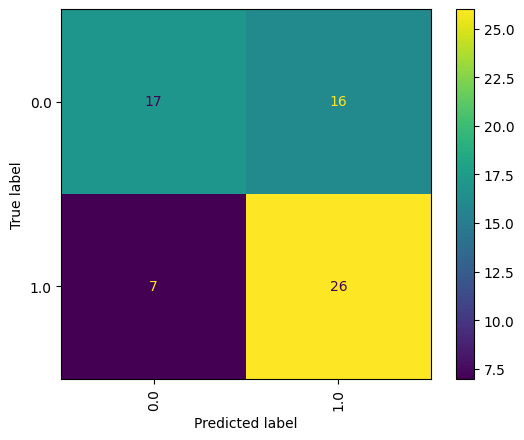

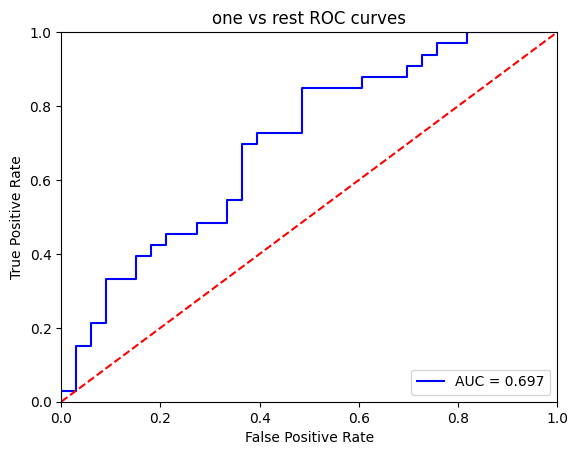

In [18]:
from PineBioML.report.utils import classification_summary

classification_summary(y_valid, y_valid_prob)

### save the model

In [19]:
from PineBioML import IO

In [20]:
IO.save_model(model, "./output/models/", "model0", overide=True)